In [1]:
import csv
import math
import requests
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def grassmask(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    lower_green = np.array([30,  40,  40])
    upper_green = np.array([90, 255, 255])
    mask = cv.inRange(hsv, lower_green, upper_green)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN,  kernel)
    return mask

In [3]:
def dirtmask(image): 
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV) 
    mask1 = cv.inRange(hsv, (  0, 30, 30), ( 30, 256, 256)) # BLUEISH
    mask2 = cv.inRange(hsv, (150, 30, 30), (180, 256, 256)) # DARKRED
    dirtmask = cv.bitwise_or(mask1, mask2) 
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)) 
    dirtmask = cv.morphologyEx(dirtmask, cv.MORPH_CLOSE, kernel) 
    dirtmask = cv.morphologyEx(dirtmask, cv.MORPH_OPEN,  kernel) 
    return dirtmask

### Cropping

In [4]:
def crop(image, pad=0.01):
    mask = grassmask(image)
    kern = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9, 9))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kern)
    cont = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    rect = cv.boundingRect(max(cont, key=cv.contourArea))
    padw = int(pad * min(image.shape[:2]))
    crop = image[
        max(0, rect[1] - padw) : min(image.shape[1], rect[1] + rect[3] + padw),
        max(0, rect[0] - padw) : min(image.shape[0], rect[0] + rect[2] + padw)
    ]
    crop = cv.resize(crop, (0, 0), fx=4, fy=4, interpolation=cv.INTER_CUBIC)
    return crop

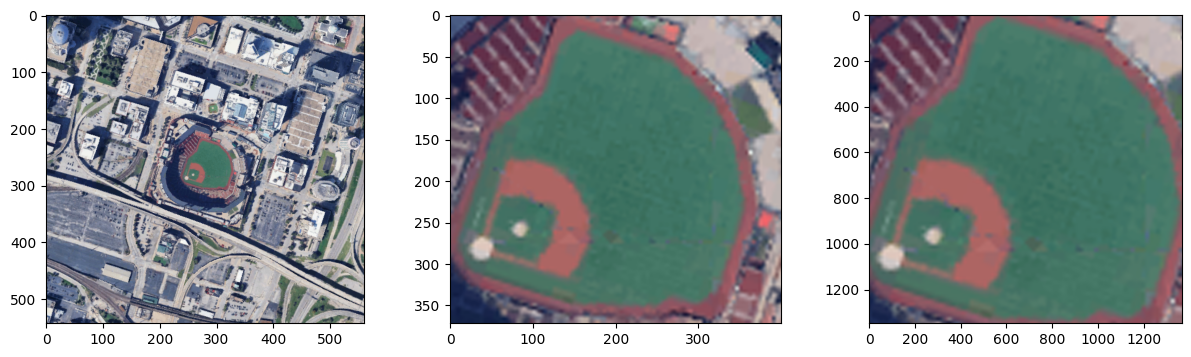

In [6]:
image = cv.imread("zoomed-out-busch.png")
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
axs[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(crop(image), cv.COLOR_BGR2RGB))
axs[2].imshow(cv.cvtColor(crop(crop(image)), cv.COLOR_BGR2RGB))
plt.show()

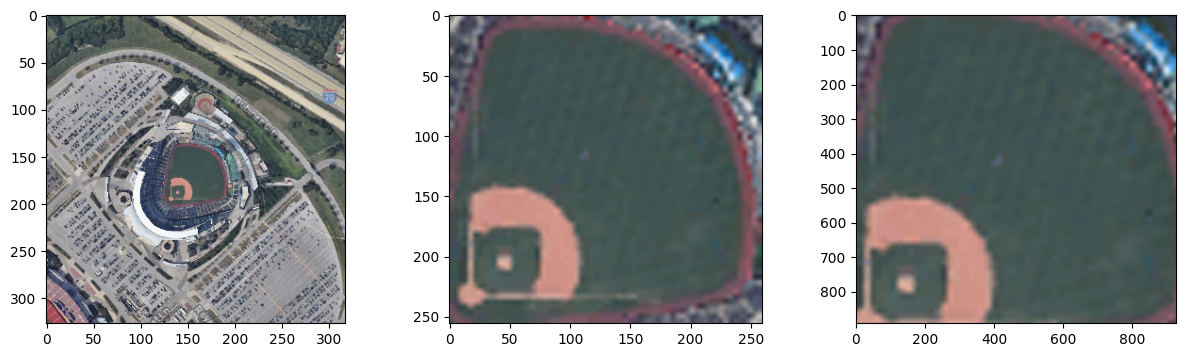

In [7]:
image = cv.imread("zoomed-out-kauffman.png")
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
axs[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(crop(image), cv.COLOR_BGR2RGB))
axs[2].imshow(cv.cvtColor(crop(crop(image)), cv.COLOR_BGR2RGB))
plt.show()

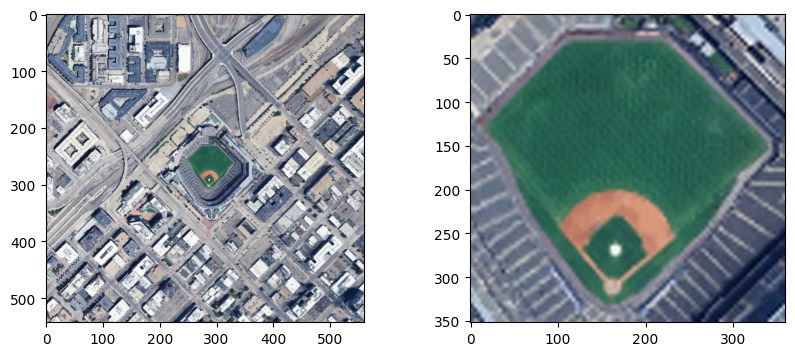

In [73]:
image = cv.imread("zoomed-out-coors.png")
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(crop(image), cv.COLOR_BGR2RGB))
plt.show()

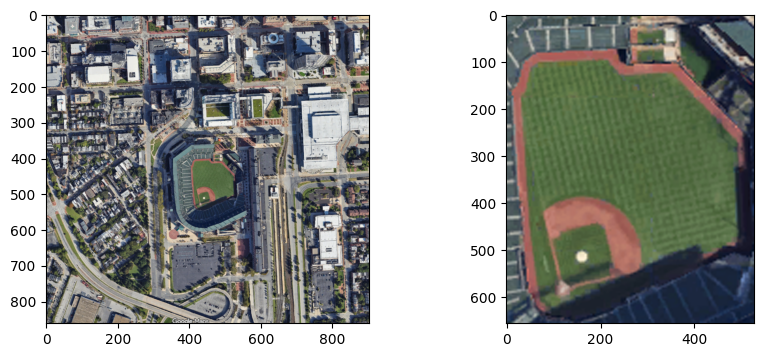

In [74]:
image = cv.imread("zoomed-out-camden.png")
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(crop(image), cv.COLOR_BGR2RGB))
plt.show()

### Rejection

In [182]:
def field_shape(field_mask, maxcont):
    _, _, w, h = cv.boundingRect(maxcont)
    if min(w / h, h / w) < 0.75:
        print("INCORRECT ASPECT RATIO")
        return False
    area = cv.contourArea(maxcont)
    peri = cv.arcLength(maxcont, True)
    if 4 * np.pi * area / peri ** 2 < 0.25:
        print("INCORRECT CIRCULARITY")
        return False
    return True

In [189]:
def field_color(field_mask, dirts_mask):
    score = 0
    pixels = np.count_nonzero(field_mask)
    dirt = np.count_nonzero(cv.bitwise_and(dirts_mask, field_mask))
    print(dirt / pixels)
    if not (0.1 <= dirt / pixels <= 0.5):
        print("INCORRECT DIRT RATIO")
        return False
    cont = cv.findContours(dirts_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    maxcont = max(cont, key=cv.contourArea)
    if cv.contourArea(maxcont) < 1000:
        print("INCORRECT DIRT CONT SIZE")
        return False
    return True

In [194]:
def isolate_field(grass_mask, dirts_mask):
    mask = cv.bitwise_or(grass_mask, dirts_mask)
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("ISOLATE FIELD: NO CONTOURS FOUND")
        return None
    if cv.contourArea(maxcont := max(contours, key=cv.contourArea)) < 5000:
        print("ISOLATE FIELD: AREA TOO SMALL")
        return None
    field_mask = np.zeros_like(mask)
    cv.drawContours(field_mask, [maxcont], -1, 255, -1)
    return field_mask
    if not field_shape(field_mask, maxcont):
        return None
    if not field_color(field_mask, dirts_mask):
        return None
    return field_mask

In [185]:
image = crop(cv.imread("zoomed-out-busch.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

In [186]:
image = crop(cv.imread("zoomed-out-camden.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

In [187]:
image = crop(cv.imread("zoomed-out-coors.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

In [195]:
image = crop(cv.imread("zoomed-out-kauffman.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

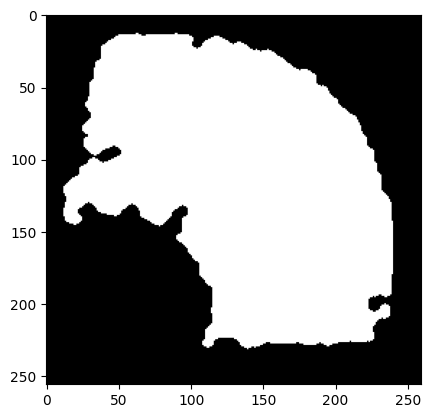

In [196]:
plt.imshow(mask, cmap="grey")
plt.show()

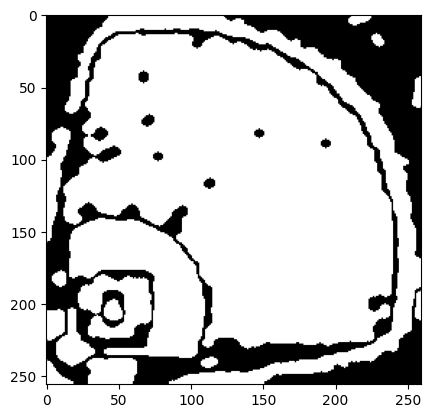

In [198]:
plt.imshow(cv.bitwise_or(grassmask(image), dirtmask(image)), cmap="grey")
plt.show()

In [191]:
image = crop(cv.imread("not-field-mtbank.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

0.009225108759647889
INCORRECT DIRT RATIO


In [192]:
image = crop(cv.imread("not-field-baltimore.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

INCORRECT ASPECT RATIO


In [193]:
image = crop(cv.imread("not-field-grasspark.png"))
mask = isolate_field(grassmask(image), dirtmask(image))

INCORRECT CIRCULARITY
